In [2]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path
from dateutil.relativedelta import relativedelta
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Masking
from tensorflow.keras.models import Model
from tqdm.keras import TqdmCallback

import seaborn as sns
from matplotlib import pyplot as plt

2023-07-24 22:57:22.590171: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 22:57:22.641865: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 22:57:22.642684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 22:57:23.472212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def get_labels(start_date, end_date):
    # Convert input dates to datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # List to store all group labels
    all_labels = pd.Series(dtype=int)

    # Initialize current date to start_date
    curr_date = start_date

    while curr_date <= end_date:
        year = curr_date.year
        month = curr_date.month

        file_name = f"/home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/{year}{month:02d}_sst_diff.nc"
        if not Path(file_name).exists():
            print(f"File {file_name} does not exist, skipping...")
            curr_date += relativedelta(months=1)
            continue
        print(f"Processing file {file_name}...")

        # Open the dataset and convert it to a pandas DataFrame
        temp = xr.open_dataset(file_name)
        temp_df = temp.to_dataframe()

        # Convert the 'time' column to date only format
        temp_df.index = pd.to_datetime(temp_df.index).date

        # Reset index to create 'time' column
        temp_df = temp_df.reset_index()

        # Create a new column 'entry_id' which enumerates each entry within each date
        temp_df['entry_id'] = temp_df.groupby('time').cumcount()

        # Filter dataframe for rows where 'entry_id' is 22 and 23, and create a copy
        filtered_df = temp_df[temp_df['entry_id'].isin([22,23])].copy()

        # Create a label column - set to 1 if SST_Diff < threshold, else set to 0
        threshold = -1
        filtered_df.loc[:, 'label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

        # Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
        group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 2 else 0)

        # Append the group_labels to all_labels
        all_labels = pd.concat([all_labels, group_labels])

        # Move to the next month
        curr_date += relativedelta(months=1)

    print(all_labels.shape)
    return all_labels

# Call the function with your specific start and end date
labels = get_labels('2020-01-01', '2022-12-31')

Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/202001_sst_diff.nc...
File /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/202002_sst_diff.nc does not exist, skipping...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/202003_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/202004_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/202005_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/202006_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/202007_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/202008_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/202009_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/202010_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/sha

In [3]:
import numpy as np

def generate_random_data(batch_size):
    """
    Generate random data of given batch size with shape (batch_size, 149, 181, 1).
    
    Parameters:
        batch_size (int): Number of random data samples to generate.
        
    Returns:
        numpy.ndarray: Random data of shape (batch_size, 149, 181, 1).
    """
    # Given the provided input shape
    height = 149
    width = 181
    depth = 1

    # Generate random data
    random_data = np.random.rand(batch_size, height, width, depth)

    return random_data

# Example usage:
batch_dim = 1067
random_data_batch = generate_random_data(batch_dim)
print(random_data_batch.shape)


(1067, 149, 181, 1)


In [6]:
all_labels_reshaped = labels.values.ravel()

In [8]:
processed_data_list = []

for day_data in random_data_batch:
    day_data = np.squeeze(day_data)

    day_data = np.flipud(day_data)

    sst_data2 = np.nanmean(day_data)

    sst_data3 = day_data - sst_data2

    processed_data_list.append(sst_data3)

processed_data = np.array(processed_data_list)

In [10]:
# Fill NaN with 0
sst_data = np.nan_to_num(processed_data, nan=0.0)

In [11]:
# Add a channel dimension
sst_data = np.expand_dims(sst_data, axis=-1)

# Flatten the data for SMOTE
sst_data_flat = sst_data.reshape(sst_data.shape[0], -1)

# Apply SMOTE
smote = SMOTE(random_state=42)
sst_data_res, labels_res = smote.fit_resample(sst_data_flat, all_labels_reshaped)

# Reshape the data to original shape
sst_data_res = sst_data_res.reshape((-1, processed_data.shape[1], processed_data.shape[2], 1))

In [23]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(sst_data_res, labels_res, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2 for validation

# Define the model
base_model = EfficientNetB0(include_top=False, weights=None, input_shape=(processed_data.shape[1], processed_data.shape[2], 1))

# Add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Let's add a fully-connected layer
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
# And a logistic layer
predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tqdm_callback = TqdmCallback(verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[tqdm_callback, early_stopping_callback], validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

13/13 [==============================] - 2s 190ms/step - loss: 2.1902 - accuracy: 0.5142
Accuracy: 0.514211893081665


In [1]:
len(labels)

NameError: name 'labels' is not defined

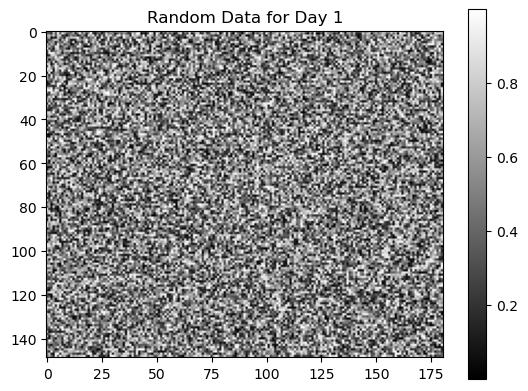

In [4]:
first_day_data = random_data_batch[0, :, :, 0]

plt.imshow(first_day_data, cmap='gray')
plt.colorbar()
plt.title("Random Data for Day 1")
plt.show()